# Tracking Lineages with SuperSegger 

In [16]:
import numpy as np
import pandas as pd
import mscl_utils as mscl
import pymc3 as pm 
import theano.tensor as tt
import bokeh.io
import glob
import bokeh.plotting
import skimage.io
import scipy.io
bokeh.io.output_notebook()

Loading BokehJS ...

This notebook demonstrates how the output from a SuperSegger session is parsed and read into Python. 

## The `Cell` File 

While supersegger outputs several useful things, the files we will be the most interested in are the `c/Cell.mat` files in each position. The structure of these ouputs are described in great detail [on the SuperSegger Wiki page](). Each individual cell has a corresponding `.mat` file which contains information about the time of birth, time of death, fluorescence information, etc. Most importantly, it contains information about its assigned ID as well as its mothers' and sister IDs. While these files exist as Matlab `.mat` files, we can easily load them in to Python using the `scipy.io.loadmat` function.

We can load an example `cell.mat` file to get the key information. 

In [2]:
# Define the data directory for a single image position. 
root_dir = '../data/images/20171017_sfGFP_10ngmL_dilution/'
data_dir = '{0}growth/xy00/cell/'.format(root_dir)

# Grab all of the mat files. Note that these exist as cell and Cell. 
files = glob.glob('{0}*.mat'.format(data_dir))
mat_file = scipy.io.loadmat(files[0]) 

# Print out the keys of the mat_file.
mat_file.keys()

dict_keys(['__header__', '__version__', '__globals__', 'CellA', 'death', 'birth', 'divide', 'sisterID', 'motherID', 'daughterID', 'ID', 'neighbors', 'stat0', 'ehist', 'contactHist'])

While this looks like a very short list, the `CellA` value is also a dictionary containing information about the segmentation mask, fluorescence, area, etc. for every frame in the time-lapse. We would like to have all cell information for a single position in a tidy pandas DataFrame. Below are two functions which do exactly that. 

In [3]:
def cell_to_dict(file, add_props=None, excluded_props=None):
    """
    Reads a single cell file and produces a dictionary containing
    the properties of interest. 
    
    The returned properties are 
    * birth - frame number at which the cell was born.
    * death - frame number at which the cell died.
    * divide - bool for an observed cell division.
    * ID - integer ID number of the cell.
    * motherID - integer ID number of the mother cell.
    * sisterID - integer ID number of the sister cell.
    * birth_fluo - fluorescence value at the cell's birth.
    * death_fluo - fluorescence value at the cell's death.
    * daughter_1_ID - integer ID number of the first daughter.
    * daughter_2_ID - integer ID number of the second daughter.
    
    
    Parameters
    ----------
    file: str
        Path of the cell file. This must be in a `.mat` format.
    add_props : dict, default None
        Dictionary of additional properties (not found in the mat file)
        to be included in the returned dictionary.
    excluded_props: list of str
        Properties of cell.mat file to be ignored. These must be 
        exactly how they are defined in the cell file.
    
    Returns
    -------
    cell_dict : dictionary
        Dictionary of all extracted properties from the cell files. 
    """
    
    # Ensure the supplied file is actually a .mat and other types are correct. 
    if file.split('.')[-1] != 'mat':
        raise TypeError("supplied file {0} is not a `.mat` file.".format(file))
    if add_props is not None and type(add_props) is not dict:
        raise TypeError("add_props is {0} and not dict.".format(type(add_props)))                  
    if excluded_props is not None and type(excluded_props) is not list:
        raise TypeError("add_props must be list. Type is currently {0}.".format(type(excluded_props)))
                        
    # Define the values of interest.
    vals = ['birth', 'death', 'divide', 'ID', 'motherID', 'sisterID', 
             'daughter_1_ID', 'daughter_2_ID', 'birth_fluo', 'death_fluo'] 
    
    # Load the mat file using MATLAB.
    mat = scipy.io.loadmat(file, squeeze_me=True,
                      chars_as_strings=True,
                      struct_as_record=True)
    
    # Assemble the dictionary for constant properties. 
    cell_dict = {v: mat[v] for v in vals[:-4]}
    daughters = mat['daughterID']
    
    # Determine  if daughters were produced. If not, change ID to NaN.
    if len(daughters) == 0:
        daughter_1, daughter_2 = None,  None
    else:
        daughter_1, daughter_2 = daughters 
    cell_dict['daughter_1_ID'] = daughter_1
    cell_dict['daughter_2_ID'] = daughter_2
     
    # Extract fluorescence information -- This is a bit gross but checked.
    cell_dict['birth_fluo'] = mat['CellA'][0]['fl1'].flatten()[0].flatten()[0][0]
    cell_dict['death_fluo'] = mat['CellA'][-1]['fl1'].flatten()[0].flatten()[0][0]
    
    # Deal with exclusion and addition of props. 
    if excluded_props is not None:
        new_dict = {}
        keys = cell_dict.keys()
        for key in keys:
            if key not in excluded_props:
                new_dict[key] = cell_dict[key]
        cell_dict = new_dict
    if add_props is not None:
        for key in add_props.keys(): 
            cell_dict[key] = add_props[key]
                        
    # Return the cell dictionary.
    return cell_dict

def parse_cell_files(files, **kwargs):
    """
    Executes cell_to_dict across a list of files and returns a Pandas DataFrame.
    """
    if type(files) is not list:
        raise TypeError("'files' is type {0} not list.".format(type(files)))
    for i, f in enumerate(files):
        cell_dict = cell_to_dict(f, **kwargs)  
        if i == 0:
            keys = cell_dict.keys()
            df = pd.DataFrame([], columns=keys)
            df = df.append(cell_dict, ignore_index=True)
        else:
            df = df.append(cell_dict, ignore_index=True)
    return df            

We can test this function out on this list of files defined above.

In [4]:
# Execute function on a single position.
cell_df = parse_cell_files(files)
cell_df.head()

,birth,death,divide,ID,motherID,sisterID,daughter_1_ID,daughter_2_ID,birth_fluo,death_fluo
0,25.0,26.0,0.0,117.0,61.0,118.0,NaN,NaN,0.0,79838.0
1,23.0,26.0,0.0,103.0,18.0,104.0,NaN,NaN,0.0,86194.0
2,21.0,26.0,0.0,88.0,0.0,0.0,NaN,NaN,0.0,153095.0
3,13.0,26.0,0.0,63.0,26.0,62.0,NaN,NaN,0.0,114741.0
4,19.0,26.0,0.0,77.0,0.0,0.0,NaN,NaN,0.0,186813.0


With this tidy dataframe, we can extract a wide variety of useful properties and even track cell lineages. An important quantity to know is the autofluorescence of a single cell. We can use this script to parse all of the images from an autofluorescence sample (also segmented via SuperSegger).

In [5]:
# Define the directory containing the autofluorescence samples. 
auto_dir = '{0}autofluorescence/xy*'.format(root_dir)
auto_positions = glob.glob(auto_dir)

# Loop through each position and parse the cell files. 
auto_dfs = []
for i, pos in enumerate(auto_positions):
    # Get the positition number. 
    num = int(pos.split('xy')[-1])
    
    # Glob the cell files and generate the Datarame.
    files = glob.glob('{0}/cell/*.mat'.format(pos))
    _df = parse_cell_files(files, add_props={'position': int(num)},
                          excluded_props=['daughter_1_ID', 'daughter_2_ID',
                                          'death_fluo', 'motherID',
                                          'sisterID','divide', 'birth', 'death'])
    auto_dfs.append(_df)
    
# Assemble all of the positions into a single DataFrame
auto_df = pd.concat(auto_dfs, axis=0)

# Compute the mean autofluorescence value. 
mean_auto = auto_df['birth_fluo'].mean()
print('The mean autofluorescence is {0:.2f} a.u. per cell.'.format(mean_auto))

The mean autofluorescence is 75055.68 a.u. per cell.


For sanity, we can plot the autofluorescence distribution.  

In [6]:
# Compute the ECDF of the data.
x, y = mscl.ecdf(auto_df['birth_fluo'])

# Set up the figure axis. 
p = mscl.bokeh_boiler(width=800, height=600,
                     x_axis_label='fluorescence (a.u.)',
                     y_axis_label='ECDF')

# Plot the data. 
p.circle(x, y, color='dodgerblue', size=3, alpha=0.5, legend='data')

# Show the mean.
p.ray(x=mean_auto, y=[0], length=0, angle=np.pi / 2, line_width=5, color='tomato', legend='mean',
     alpha=0.5)
bokeh.io.show(p)

## Mapping the lineages 

To ensure that the experiment is working as advertised, it's important to show that the total fluorescence is conserved across a lineage. This means that the total fluorescence of a mother cell should be equivalent to the sum of the total fluorescence of all of its daughters. To ensure this is the case, we must be able to identify lineages. As we have information about the mother cell ID, the sister IDs, and the daughter ID's, piecing together the family tree should be relatively trivial. 

For this section, we will use all of the data available.

In [7]:
# Assemble the entire DataFrame.
data_dir = '{0}growth/xy*'.format(root_dir)

# Grab all of the positions.
positions = glob.glob(data_dir)

# Loop through each position and generate the DataFrame.
for i, pos in enumerate(positions):
    # Figure out the position number.
    num = int(pos.split('xy')[-1])
    
    # Grab all of the files.
    files = glob.glob('{0}/cell/*.mat'.format(pos))
    
    # Generate the DataFrame.
    _df = parse_cell_files(files, add_props={'position': num})
    if i == 0:
        df = _df
    else:
        df = df.append(_df, ignore_index=True) 

As we only care about lineages, we can consider only the cells that divided and the cells that died on the last frame. 

In [8]:
# Find only the dividing cells & the final position.
producers = df.loc[(df['divide']==1.0) | (df['death']==26)].copy()

All of the original mother cells are those present only in the first frame. As these produced all offspring, we can assign a new column to the DataFrame indicating their ID as a lineage identifier,hereafter called a `tree_number`. 

In [9]:
# Define the tree number for those without a clear parent.
producers.loc[:, 'tree_number'] = np.nan
producers.loc[producers['motherID']==0, 'tree_number'] = producers['ID']

We can now separate the DataFrame into two groups $-$ `assigned` and `unassigned` $-$ and change the tree number of their daughters to the correct lineage. As we have mixed positions with degenerate ID numbers, we will have do this in a group.

In [10]:
# Group the DataFrame by position.
grouped = producers.groupby(['position'])
position_dfs = []  # Position dataframes will be added here. 
for g, d in grouped:
    # Determine if there are orphans. 
    orphans = d[d['death']!=26]['tree_number'].isnull().values.any()
    
    # Set an iteration counter as a killswitch.
    it_counter = 0
    # Break producers into assigned and unassigned.
    assigned = d.loc[~d['tree_number'].isnull()].copy()
    unassigned = d.loc[d['tree_number'].isnull()].copy()
    while (orphans == True)  & (it_counter < 50): 
        # Get a list of all of the progeny.
        daughters = assigned.loc[:, ('daughter_1_ID', 'daughter_2_ID')].values
        tree_numbers = assigned.loc[:, 'tree_number'].values
    
        # Iterate through all of the unassigned.
        for i in range(len(unassigned)):
            cell_id = unassigned.iloc[i]['ID']
            ind = np.where([cell_id in v for v in daughters])[0]
            if len(ind) != 0:
                tree_number = tree_numbers[ind]
                unassigned.loc[unassigned['ID']==cell_id, 'tree_number'] = tree_number
        
        # Concatenate the assigned and unassigned into a new producers dataframe.
        tree = pd.concat([assigned, unassigned], axis=0, ignore_index=True)
        
        # Determine if there are any remaining orphans.
        orphans = tree[tree['death']!=26]['tree_number'].isnull().values.any()

        # Redefine the assignments.
        assigned = tree.loc[~tree['tree_number'].isnull()].copy()
        unassigned = tree.loc[tree['tree_number'].isnull()].copy()
        it_counter += 1     
         
    # Add the resultant DataFrame to the storage list. 
    position_dfs.append(tree) 
    
lineages = pd.concat(position_dfs, axis=0)

With all of the lineage number assigned, we can now loop through each pairing and compute the quantities of interest.  

In [11]:
# Restrict the data set to only those which fluorescence measurements. 
fluo_data = lineages.loc[(lineages['birth_fluo'] > 0) | (lineages['death_fluo'] > 0)].copy()

# Group by the tree number.
grouped = fluo_data.groupby(['position', 'tree_number'])

# Loop through each and compute the total fluorescence.
mother_cell, summed_daughters = [], []
for g, d in grouped:
    if (len(d) != 1) & (d['birth_fluo'].sum() > 0) & (d['death_fluo'].sum() > 0):
        mother_cell.append((d['birth_fluo']).sum())
        summed_daughters.append((d['death_fluo']).sum())  
mother_cell = np.array(mother_cell)
summed_daughters = np.array(summed_daughters)

To see if things make sense, we can plot the two quantities against each other. If the fluorescence is conserved, we would expect a 
linear relationship.

In [12]:
# Compute an expected linear predictor
x = np.linspace(mother_cell.min() - 100, mother_cell.max() + 100, 300)

# Set up the figure axis.
p = mscl.bokeh_boiler(width=800, height=600,
                      x_axis_label='mother cell intenisty (a.u.)',
                     y_axis_label='summed daughter cell intensity (a.u.)')

# Plot the data and prediction. 
p.circle(mother_cell, summed_daughters, color='slategray', alpha=0.5,
        legend='data')
p.line(x, x, color='dodgerblue', line_width=2, legend='conserved fluorescence')


# Show the plot.
bokeh.io.show(p)

##  Computing the calibration factor

As a reminder, we predict that the intensity of a single cell $I$ should be proportional to the number of fluorescent proteins per cell $N$ multiplied by some calibration factor $\alpha$,

$$
I = \alpha N.
$$

To estimate the value of $\alpha$, we can look at how the intensity fluctuates between any two daughter cells, revealing information about the partitioning of proteins during a division event. Once the mathematical dust settles, we find that relationship to be

$$
\langle (I_1 - I_2)^2 \rangle = \alpha I_\text{tot}
$$

where $I_1$ and $I_2$ are the intensities of the two daughter cells and $I_\text{tot}$ is the sum $I_1 + I_2$.  

To get a better sense of the value, we

In [18]:
# Only look at cells who died on the final frame.
final_position = df[df['death']==26]
grouped = final_position.groupby(['position', 'motherID'])

# Make a new DataFrame to store the information.
int_df = pd.DataFrame([], columns=['I_1', 'I_2', 'I_tot', 'sq_diff'])
for g, d in grouped:
    if len(d) == 2:
        daughter_fluo = d['death_fluo'].values - mean_auto 
        I_tot = daughter_fluo.sum()
        sq_diff = np.diff(daughter_fluo)[0]**2
        int_df = int_df.append(dict(I_tot=I_tot, sq_diff=sq_diff,
                                   I_1=daughter_fluo[0], I_2=daughter_fluo[1]),
                              ignore_index=True)
        
# Compute the log of the values. 
log_I_tot = np.log10(int_df['I_tot'].values)
log_sq_diff = np.log10(int_df['sq_diff'].values)

In [26]:
# Plot the results. 
p = mscl.bokeh_boiler(width=600, height=400,
                      x_axis_label='log\u2081\u2080 (I\u2081 + I\u2082)',
                      y_axis_label='log\u2081\u2080 (I\u2081 - I\u2082)\u00B2')
p.circle(x=log_I_tot, y=log_sq_diff, color='slategray', alpha=0.5)
bokeh.io.show(p)

In [51]:
class MarginalizedMvNormal(pm.Continuous):
    """
    A bivariate Normal distribution after marginalization of sigma.
        
    g(µ1, µ2, k| y1, y2) = (Σ((y1 - μ1)^2 + (y2 - μ2)^2))^(-k/2)     
     
    Parameters
    ----------
    mu1, mu2 : PyMC3 RV objects
        The two means of the components of the distribution.
    
    """
    def __init__(self, mu_array=None, ntot=None, *args, **kwargs):  
        super(MarginalizedMvNormal, self).__init__(*args, **kwargs)
        self.mu_array = mu_array = pm.theanof.floatX(tt.as_tensor_variable(mu_array))
 
    def logp(self, values): 
        k = values[0].shape[-1]
        mu_array = self.mu_array
        return -0.5 * k * tt.log(tt.sum(tt.sum((values - mu_array)**2)))
                         

In [52]:
# Define the model.
n_cells = len(int_df)
with pm.Model() as model:
    
    # Define the priors. 
    alpha = pm.Uniform('alpha', lower=0, upper=1E6) 
    
    # Take the Normal approximation of binomial. 
    ntot = pm.DiscreteUniform('N_tot', lower=0, upper=1E6, shape=n_cells)
    n1 = pm.Binomial('N_1', n=ntot, p=0.5, shape=n_cells)
    n2 = ntot - n1
     
    # Compute the means and covariance matrix for the Student-t for the Intensity likelihood.
    mu_1 = alpha * n1
    mu_2 = alpha * n2
    mus = [mu_1, mu_2] 
    
    # Define the observables.
    obs = np.array([int_df['I_1'].values, int_df['I_2'].values])
   
    # Assign the likelihood function
    likelihood = MarginalizedMvNormal('likelihood', mu_array=mus, observed=obs)

In [53]:
with model:
    trace = pm.sample(draws=5000, tune=10000)

Assigned NUTS to alpha_interval__
Assigned Metropolis to N_tot
Assigned Metropolis to N_1
100%|██████████| 15000/15000 [06:13<00:00, 40.18it/s]


In [31]:
%matplotlib inline
import corner

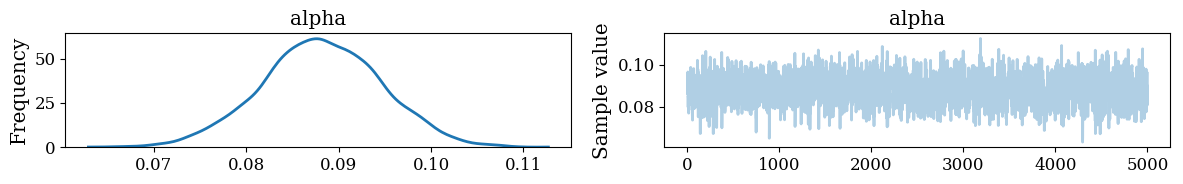

In [54]:
_ = pm.traceplot(trace, varnames=['alpha'])
df = pm.trace_to_dataframe(trace)
df['logp'] = pm.stats._log_post_trace(trace=trace, model=model).sum(axis=1)

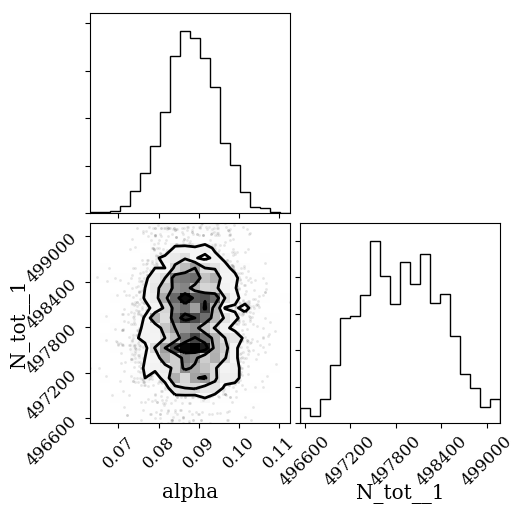

In [55]:
sub_df = df[['alpha', 'N_tot__1']]
_ = corner.corner(sub_df)

In [42]:
# Find the mode + hpd of alpha. 
alpha_mode = df.iloc[np.argmax(df['logp'])]['alpha'] 

In [48]:
# Plot the results. 
p = mscl.bokeh_boiler(width=600, height=400, x_axis_type='log', y_axis_type='log',
                      x_axis_label='(I\u2081 + I\u2082)',
                      y_axis_label='(I\u2081 - I\u2082)\u00B2')
I_tot_range = np.logspace(2, 6, 300)
p.circle(x='I_tot', y='sq_diff', source=int_df, color='slategray', alpha=0.5)
p.line(x=I_tot_range, y = alpha_mode * I_tot_range, color='dodgerblue')
bokeh.io.show(p)